# LangGraph for Agentic AI – Workshop Notebook

# Section 1: Introduction to Agentic AI

Agentic AI are systems that can perceive, reason, and act toward a goal. In practice, we combine:
- An LLM for reasoning
- Tools (functions/APIs)
- Memory/state across steps
- A controller that decides *what happens next*

We'll use **LangGraph** to build that controller as a graph. This notebook mirrors the code style used in the Hugging Face Agents course unit on LangGraph.



# Section 2: Install & Setup (run first)


In [ ]:
%pip install -U pip setuptools wheel

# Core libs (pins chosen to work well together on 3.11–3.13)
%pip install \
  "langgraph>=0.2.32" \
  "langchain>=0.2.16" \
  "langchain-core>=0.2.38" \
  "langchain-openai>=0.1.24" \
  "langchain-community>=0.2.0" \
  "ollama>=0.3.0" \
  "pydantic<3" \
  ipykernel

# --- Print versions to confirm everything is wired up ---
import sys, importlib, shutil
print("Python:", sys.version)

def ver(mod):
    try:
        m = importlib.import_module(mod)
        return getattr(m, "__version__", "unknown")
    except Exception as e:
        return f"not installed ({e})"

print("langgraph         :", ver("langgraph"))
print("langchain         :", ver("langchain"))
print("langchain_core    :", ver("langchain_core"))
print("langchain_openai  :", ver("langchain_openai"))
print("langchain_community:", ver("langchain_community"))
print("ollama (python pkg):", ver("ollama"))

# --- Optional: if the Ollama CLI is installed, show models and (optionally) pull one ---
if shutil.which("ollama"):
    import subprocess
    print("\n✅ Ollama CLI detected. Installed models:")
    try:
        print(subprocess.check_output(["ollama", "list"], text=True))
    except Exception as e:
        print("Couldn't list Ollama models:", e)
else:
    print("\nOllama CLI not found. Install from https://ollama.com and run `ollama pull llama3.2` in a terminal if you want local LLMs.")


import os
from IPython.display import Markdown, display
def md(x):
    display(Markdown(x))

# ---- LangChain compatibility shims (run FIRST, before any ChatOpenAI usage) ----
try:
    import langchain as _lc
    if not hasattr(_lc, "debug"):
        _lc.debug = False
    if not hasattr(_lc, "verbose"):
        _lc.verbose = False
    if not hasattr(_lc, "llm_cache"):
        _lc.llm_cache = None  # satisfy get_llm_cache() fallback path
except Exception:
    # If langchain isn't installed, fine; cells that use it will install/import later.
    pass



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Python: 3.13.3 (tags/v3.13.3:6280bb5, Apr  8 2025, 14:47:33) [MSC v.1943 64 bit (AMD64)]
langgraph         : unknown
langchain         : 0.3.27
langchain_core    : 0.3.74
langchain_openai  : unknown
langchain_community: 0.3.27
ollama (python pkg): unknown

✅ Ollama CLI detected. Installed models:
NAME         ID              SIZE      MODIFIED     
gemma3:1b    2d27a774bc62    815 MB    7 months ago    



# Section 3: Graph Theory Primer (mapped to LangGraph)

## 📌 What is a Graph?
In mathematics and computer science, a **graph** is a structure made up of:
- **Nodes (or vertices):** the points or entities in the graph.
- **Edges (or links):** the connections between nodes.

Graphs are powerful because they describe **flows** or **relationships**.  
For example:
- In social networks, nodes are people and edges are friendships.  
- In LangGraph, nodes are computation steps, and edges are transitions between them.

**Graph theory essentials (as used in LangGraph):**
- **Node**: a step of computation or a 'doing' task (e.g., call an LLM, run a tool, do routing).
- **Edge**: a possible transition from one node to another. An edge indicates that in the flow of the program, one node is possible to reach as a result from another node
- **State**: the evolving memory passed along edges (e.g., messages list, intermediate values). Much like a function outputs a result, a state is the output of a node which is then used to decide what edges are traversed in the graph.
- **Graph**: Execution of the whole program encompassing all available states, nodes and edges. The graph shows all possibilities.

**What are *tools*? (graph-theoretic view)**
- In agent frameworks, a **tool** is a typed, callable function (or API) that performs work the LLM cannot do by itself—math, web calls, database queries, file I/O, etc.
- In graph terms, tools are **action nodes** (functions) that consume part of the state and emit outputs that get merged back into state.
- A common pattern is **Model → Tool → Model**: the model node proposes a tool call; an edge routes to a tool node; the tool returns a **ToolMessage** that is appended to messages; control edges loop back to the model.
- Tools may also be modeled as **subgraphs** (a mini workflow) if they require multiple steps.

LangGraph provides helpful defaults:
- A **messages-first** state for chat-style agents.
- Special sentinels **START** and **END** which signify the end points of the flow.
- Easy patterns for tool-use and conditional routing.

Functions to Follow:
- Use `MessagesState` (a dictionary with a `messages` list of LangChain messages)
- Define a `StateGraph(AgentState)`
- Add nodes for the model and tools
- Route with `add_conditional_edges`

**Quick checks to do during this notebook:**
- Identify the **nodes** in the Model–Tools loop.
- Where are the **edges** that implement the loop?
- Which part of the state changes after a tool runs?



# Section 4: Minimal Graph – Echo (messages-first)


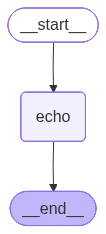

Echoing message:
response: echo: hello


In [2]:
# Compatible with Python 3.11–3.13

from typing import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# --- Optional safety shim for some langchain/langchain-core combos ---
try:
    import langchain  # not strictly needed for this echo graph, but many envs have it
    if not hasattr(langchain, "debug"):
        # Prevents AttributeError in some callback paths under certain version mixes
        langchain.debug = False
except Exception:
    # If langchain isn't installed, that's fine for this example
    pass

# --- State schema ---
class MessageState(TypedDict):
    message: str   # input message from the user
    response: str  # output from the echo node

# --- Node: echo the message ---
def echo_node(state: MessageState) -> MessageState:
    input_message = state["message"]
    print("Echoing message:")
    # Return BOTH message and response to keep state consistent across merges
    return {
        "message": input_message,
        "response": f"echo: {input_message}",
    }

# --- Build graph ---
builder = StateGraph(MessageState)
builder.add_node("echo", echo_node)
builder.add_edge(START, "echo")
builder.add_edge("echo", END)

echo_graph = builder.compile()

# --- Try to render the graph (PNG). Fallback to Mermaid if renderer not available. ---
try:
    png = echo_graph.get_graph().draw_mermaid_png()
    display(Image(png))
except Exception as e:
    print("Mermaid render fallback (PNG unavailable):")
    try:
        print(echo_graph.get_graph().draw_mermaid())
    except Exception:
        print("Mermaid text not available in this environment.")

# --- Run ---
result = echo_graph.invoke({"message": "hello"})
print("response:", result.get("response"))


## Why define a `State` even for a simple echo?

Even though this echo example could pass a plain `dict` (or even just a string), **explicit state** is good practice in LangGraph because it scales with your agent as you add nodes and edges.

**What “state” means here**
- The **state** is the evolving payload that flows along **edges** and is read/updated by **nodes**.
- In code, we model it with a schema (e.g., `TypedDict`) so each node knows which keys it can rely on and which keys it may write.

**Benefits now and later**
- **Clarity & contracts:** `TypedDict` documents what data exists (`message`, `response`), acting as a contract between nodes. Future nodes (e.g., classifiers, tools, memory) can add fields without breaking others.
- **Type safety & IDE help:** Better autocompletion and early errors (missing keys, wrong types) vs. debugging runtime `KeyError`s.
- **Composable graphs:** When you add branches/loops (more edges), multiple nodes can coordinate via shared keys in the state instead of ad-hoc globals/return shapes.
- **Debuggability:** You can log/inspect the state at each step to see how data changes across the graph (great for tests and tracing).
- **Evolution-friendly:** As your agent grows (LLM calls, tools, retries, memory), you can extend the state (e.g., `tool_calls`, `draft`, `tokens_used`, `trace_id`) without rewriting existing nodes.

**Graph-theoretic mapping**
- **Nodes** = steps that read → transform → write parts of the state.
- **Edges** = control flow deciding which node runs next.
- **State** = the shared data structure carried along edges (the “payload” of the walk through the graph).

**Rule of thumb**
- For tiny demos, a loose `dict` works.
- For anything you plan to **teach, maintain, or extend**, define a state schema (e.g., `TypedDict`, `dataclass`, or `pydantic` model). It keeps your agent robust as complexity grows.


# === Exercise 1 ===
Change the tool (function) echo_node so it also appends the message length, e.g. "Echo (len=5): ..."
Tip: the len(text) function will compute how many characters are in the variable text given that text is a String type


# Section 5: Model + Tools Agent

From graph theory: an action node in your graph. It consumes state, performs work, and returns results that update the state.
Patterns Used:
1) Bind tools to the model (so the model can emit **tool_calls**)
2) A **model node** that appends its AIMessage (may include tool calls)
3) A **ToolNode** that executes tool calls and returns ToolMessages
4) A **router** that loops back to the model if tool calls were made, else END

**How this maps to graph theory:**
- Nodes: `model` and `tools` (plus `START`/`END` sentinels)
- Edges: `START → model`, conditional `model → tools` or `model → END`, and `tools → model`
- State: `messages` augmented with `ToolMessage` outputs, giving the model new context for the next step
- Tools: callable action nodes bound to the model via `bind_tools`

C:\Users\wenas\AppData\Local\Temp\ipykernel_6540\2466397218.py:16: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  _local_llm = ChatOllama(model="gemma3:1b", temperature=0)


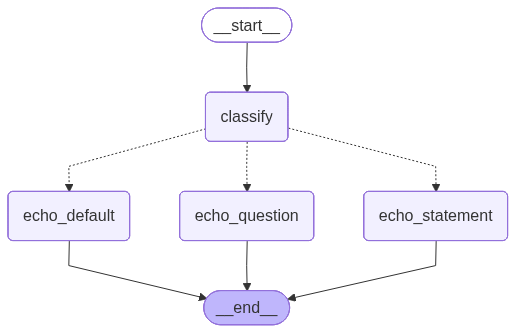

question: Is this working?
statement: This is a simple statement
echo: ???!!!


In [3]:
# --- Branch based on classification into different echo nodes ---
import os

# 1) Update state to keep classification result
class MessageState(TypedDict):
    message: str        # input message
    kind: str           # classification: "question", "statement", or "unknown"
    response: str       # output from one of the echo nodes

# --- AI tool: classify "question" vs "statement" vs "unknown" ---
from langchain_core.tools import tool
from langchain_community.chat_models import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage

#use local AI ollama for AI based tool
_local_llm = ChatOllama(model="gemma3:1b", temperature=0)

@tool
def classify_message_tool(message: str) -> str:
    """
    Local LLM classifier via Ollama.
    Returns: 'question' | 'statement' | 'unknown'
    """
    msg = (message or "").strip()
    if not msg:
        return "unknown"
    if msg.endswith("?"):
        return "question"   #local shortcut to determine questions easily (can be edited for individual use case based on AI model power)

    sys = ("You are a strict classifier. "
           "Return exactly one token: question, statement, or unknown.")
    ai = _local_llm.invoke([SystemMessage(content=sys), HumanMessage(content=msg)])
    out = (ai.content or "").strip().lower()
    return out if out in {"question","statement","unknown"} else "unknown"

# 2) Node: classify message
def classify_node(state: MessageState) -> MessageState:
    kind = classify_message_tool.invoke({"message": state["message"]})
    # Normalize output
    kind = kind.strip().lower()
    if kind not in ["question", "statement"]:
        kind = "unknown"
    #print(f"Classified as: {kind}")
    return {"kind": kind}

# 3) Echo nodes
def echo_question_node(state: MessageState) -> MessageState:
    return {"response": f"question: {state['message']}"}

def echo_statement_node(state: MessageState) -> MessageState:
    return {"response": f"statement: {state['message']}"}

def echo_default_node(state: MessageState) -> MessageState:
    return {"response": f"echo: {state['message']}"}

# 4) Router: decide which echo node to run
def route_by_kind(state: MessageState):
    kind = state.get("kind", "unknown")
    if kind == "question":
        return "echo_question"
    elif kind == "statement":
        return "echo_statement"
    else:
        return "echo_default"

# 5) Build the graph
builder = StateGraph(MessageState)
builder.add_node("classify", classify_node)
builder.add_node("echo_question", echo_question_node)
builder.add_node("echo_statement", echo_statement_node)
builder.add_node("echo_default", echo_default_node)

builder.add_edge(START, "classify")
builder.add_conditional_edges("classify", route_by_kind, {
    "echo_question": "echo_question",
    "echo_statement": "echo_statement",
    "echo_default": "echo_default"
})
builder.add_edge("echo_question", END)
builder.add_edge("echo_statement", END)
builder.add_edge("echo_default", END)

branch_graph = builder.compile()

# Visualize
display(Image(branch_graph.get_graph().draw_mermaid_png()))

# Try it out

print(branch_graph.invoke({"message": "Is this working?"})["response"])     # should go to echo_question
print(branch_graph.invoke({"message": "This is a simple statement"})["response"])  # should go to echo_statement
print(branch_graph.invoke({"message": "???!!!"})["response"])               # should go to echo_default



=== Exercise 2 ===
Add a new @tool named `translate_to_jp(text: str)` that returns a naive English->Japanese placeholder
(e.g., prefix with "[JP]" or craft a tiny mapping). Bind it, and update the graph to support it.
Prompt: "Translate to Japanese: good morning" should cause a tool call.


# Section 6: Multimodel Tools


Sometimes you want classic branching based on content (not tool calls). We'll add a router node that:
- If input starts with "Translate:", jump to a translate node
- Else, use the model/tools loop above

**Graph view:**
- Nodes: `translate`, `model`, `tools`
- Edges: `START → (translate|model)` via a conditional router; `model → tools|END`; `tools → model`
- State: still `messages`; the translate node writes an `AIMessage` directly


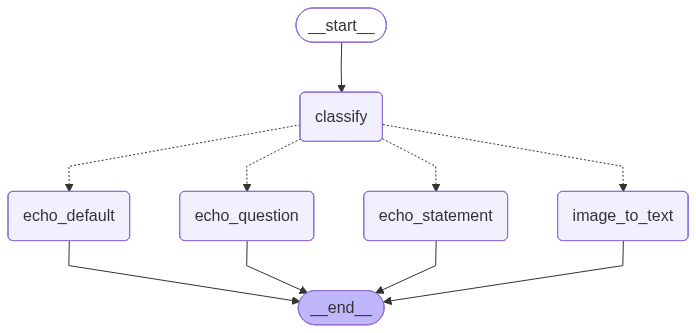

question: Is this working?
statement: This is a simple statement


In [4]:
# ============================================
# Multimodal "image → text" tool using Ollama
# ============================================
# 1) Adds a new node `image_to_text_node` into your LangGraph that triggers when
#    the user's message starts with "image:".
# 2) Rebuilds the graph as `branch_graph_v2` with a router that sends image messages
#    to the new multimodal node, while keeping your original text-only flow intact.

import os, base64, mimetypes
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.tools import tool
from langchain_community.chat_models import ChatOllama

# -------------------------------
# 0) Configure the vision model
# -------------------------------
# We instantiate a LangChain chat model that talks to your local Ollama server.
# `llava` is a common open-source vision model that can caption images.
# If you pulled a different model name (e.g., "moondream" or "bakllava"),
# change the `model=` value below to match.
vision_llm = ChatOllama(model="llava", temperature=0)

# Turn a local image file into a data: URL (Optional: can be ignored as not part of the core class)
# ------------------------------------------------------
# Ollama's multimodal interface (via LangChain) can accept local paths OR
# base64-encoded "data URLs". We’ll create a helper that:
# - If given a local file path, reads the bytes and returns a data URL
# - If given an http(s) URL or an existing data URL, just returns it as-is
def to_data_url(image_path_or_url: str) -> str:
    img = (image_path_or_url or "").strip()
    if img.lower().startswith(("http://", "https://", "data:")):
        # Passing a URL through directly. Note: some local models are more
        # reliable with local files/data-urls than remote URLs.
        return img

    # Treat as a local file: guess the MIME, base64-encode, and wrap as data URL
    mime, _ = mimetypes.guess_type(img)
    if not mime:
        mime = "image/jpeg"
    with open(img, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")
    return f"data:{mime};base64,{b64}"

# ----------------------------------------------------------
# 2) Define a LangChain Tool: `image_to_text_tool(image, prompt)`
# ----------------------------------------------------------
# - Once again, `@tool` wraps a normal Python function so it can be called in tool-aware flows.
# - We call the local vision model with:
#     - user text (our prompt/question)
#     - the image content (as a data URL or URL) via the `images=[...]` kwarg.
# - We return the model’s textual description.
@tool
def image_to_text_tool(image: str, prompt: str = "Describe the image accurately and succinctly.") -> str:
    """
    Use a local Ollama vision model (e.g. `llava`) to convert an image into text.
    Args:
        image: Local file path, http(s) URL, or data URL.
        prompt: Optional instruction about what to extract from the image.
    Returns:
        A text description generated by the model.
    """
    # Convert local file to data URL if needed
    img_ref = to_data_url(image)

    # ChatOllama (vision) accepts a text prompt plus an `images=[...]` argument.
    # Under the hood, LangChain packages this for Ollama's multimodal endpoint.
    result = vision_llm.invoke(prompt, images=[img_ref])

    # LangChain returns an object with a `.content` string
    return (getattr(result, "content", "") or "").strip()

# ----------------------------------------------------------------
# 3) A new node function for your graph: `image_to_text_node(state)`
# ----------------------------------------------------------------
# - This node is a tiny adapter that:
#   a) Parses messages that start with "image:"
#   b) Extracts the image reference + optional custom prompt
#   c) Calls the tool and places the caption into `state["response"]`
#
# Supported message formats your students can try:
#   "image: ./cat.jpg"
#   "image: ./cat.jpg | prompt=List key objects and any visible text."
def image_to_text_node(state: "MessageState") -> "MessageState":
    msg = (state.get("message") or "").strip()
    if not msg.lower().startswith("image:"):
        return {"response": "No image directive provided."}

    # Pull out "image: <payload>"
    payload = msg.split("image:", 1)[1].strip()

    # Optional inline custom prompt using the pattern:  | prompt=...
    # e.g., "image: ./sample.jpg | prompt=Extract any visible text"
    image_ref = payload
    custom_prompt = ""
    if "| prompt=" in payload:
        image_ref, custom_prompt = payload.split("| prompt=", 1)
        image_ref = image_ref.strip()
        custom_prompt = custom_prompt.strip()

    if not image_ref:
        return {"response": "You wrote 'image:' but didn’t provide a path or URL."}

    # Call the LangChain Tool (note we pass a dict of arguments to .invoke)
    desc = image_to_text_tool.invoke({"image": image_ref, "prompt": custom_prompt or "Describe the image."})

    return {"response": f"Image description: {desc}"}

# ------------------------------------------------------------------
# 4) Updated router: route 'image:' messages to the new vision node
# ------------------------------------------------------------------
# - We intercept messages that start with "image:" BEFORE doing text-only routing,
#   then fall back to your original question/statement/unknown paths.
def route_with_image(state: "MessageState"):
    msg = (state.get("message") or "").strip().lower()
    if msg.startswith("image:"):
        return "image_to_text"
    kind = state.get("kind", "unknown")
    if kind == "question":
        return "echo_question"
    elif kind == "statement":
        return "echo_statement"
    else:
        return "echo_default"

# ------------------------------------------------------------------
# 5) Rebuild the graph with the new node (keeps your existing nodes)
# ------------------------------------------------------------------
# We reuse the original node functions you already defined in a previous cell:
#   - classify_node
#   - echo_question_node
#   - echo_statement_node
#   - echo_default_node
# And we extend the graph to include `image_to_text`.
builder2 = StateGraph(globals()["MessageState"])

builder2.add_node("classify", globals()["classify_node"])
builder2.add_node("echo_question", globals()["echo_question_node"])
builder2.add_node("echo_statement", globals()["echo_statement_node"])
builder2.add_node("echo_default", globals()["echo_default_node"])
builder2.add_node("image_to_text", image_to_text_node)

# Flow:
# START -> classify -> (conditional) -> one of the nodes -> END
builder2.add_edge(START, "classify")
builder2.add_conditional_edges(
    "classify",
    route_with_image,
    {
        "image_to_text": "image_to_text",
        "echo_question": "echo_question",
        "echo_statement": "echo_statement",
        "echo_default": "echo_default",
    },
)
builder2.add_edge("image_to_text", END)
builder2.add_edge("echo_question", END)
builder2.add_edge("echo_statement", END)
builder2.add_edge("echo_default", END)

branch_graph_v2 = builder2.compile()

# ------------------------------------------
# 6) (Optional) Visualise + quick smoke test
# ------------------------------------------
try:
    from IPython.display import display
    from PIL import Image as _PILImage  # only needed to sanity-check local paths
    display(Image(branch_graph_v2.get_graph().draw_mermaid_png()))
except Exception:
    pass

# Text-only demos (should behave like your previous graph):
print(branch_graph_v2.invoke({"message": "Is this working?"})["response"])
print(branch_graph_v2.invoke({"message": "This is a simple statement"})["response"])

# Image demo:
# Replace './sample.jpg' with a real path on your machine:
# print(branch_graph_v2.invoke({"message": "image: ./sample.jpg"})["response"])
# Or with a custom prompt:
# print(branch_graph_v2.invoke({"message": "image: ./sample.jpg | prompt=List key objects and any visible text."})["response"])


=== Exercise 3 ===
Try and replace llava with another image to text tool.


# Section 7: Pros & Cons – LangGraph vs LangChain (freedom & control)

**LangGraph**
- ✅ Pros: explicit nodes/edges; deterministic control; great for tool loops; easier debugging/visualization; production-friendly
- ⚠️ Cons: more boilerplate; steeper learning curve vs simple chains

**LangChain (chains/agents)**
- ✅ Pros: very fast to prototype; lots of prebuilt components; minimal code
- ⚠️ Cons: less control over flow; harder to reason about long/branchy behaviors

**Rule of thumb**: Rapid prototype → LangChain; Production agent with custom control → LangGraph.


# Section 8: Optional Challenge – Tiny RAG Tool


Add a small in-memory knowledge base + a `search_kb(query)` tool that returns top-1 snippet.
Have the model decide when to call `search_kb` vs answering directly, using the same tools loop.
Test with a query that is only answerable via the KB.
